In [1]:
import keras
import os
import pandas as pd, numpy as np
import cv2, imutils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from hyperopt.pyll.base import scope 
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import shutil

In [2]:
cwd = os.getcwd()
pre_csv = os.path.abspath(os.path.join(os.sep, cwd, '..', 'neural_network', 'augmentation_data.csv'))
df = pd.read_csv(pre_csv)

In [3]:
def getFullImagePath(full_path):
    sub_image_path = full_path
    split_sub_image_path = sub_image_path.split("/")
    image_path = ""
    if(len(split_sub_image_path) == 2):
        image_path = os.path.abspath(os.path.join(os.sep, cwd, "..", "neural_network", "augmentation", split_sub_image_path[0], split_sub_image_path[1]))
    else:
        image_path = os.path.abspath(os.path.join(os.sep, cwd, "..", "neural_network", "augmentation", sub_image_path))
    return image_path

In [4]:
count = [0 for x in range(8)]
raw_images =  []
labels = []
for i, row in df.iterrows():
    image_path = getFullImagePath(row.image)

    image = cv2.imread(image_path)
    image = cv2.resize(image, (112, 112), interpolation = cv2.INTER_AREA)
    pixels = image.flatten()
    raw_images.append(pixels)
    
    label = row.emotion
    labels.append(label)
    
    count[row.emotion] += 1
    if i > 0 and i % 10000 == 0: print('[INFO] processed {}/{}'.format(i, len(df)))
    
print(count)

[INFO] processed 10000/77205
[INFO] processed 20000/77205
[INFO] processed 30000/77205
[INFO] processed 40000/77205
[INFO] processed 50000/77205
[INFO] processed 60000/77205
[INFO] processed 70000/77205
[9948, 8812, 9692, 10002, 10001, 10001, 10001, 8748]


In [ ]:
space = {
    'rate'       : hp.uniform('rate', 0.01, 0.5),
    'dropout'    : hp.uniform('dropout', 0.01, 0.5),
    'units1'      : scope.int(hp.quniform('units1', 10, 100, 5)),
    'units2'      : scope.int(hp.quniform('units2', 10, 100, 5)),
    'units3'      : scope.int(hp.quniform('units3', 10, 100, 5)),
    'units4'      : scope.int(hp.quniform('units4', 10, 100, 5)),
    'batch_size' : scope.int(hp.quniform('batch_size', 100, 250, 25)),
    'layers'     : scope.int(hp.quniform('layers', 3, 4, 1)),
    'optimizer'  : hp.choice('optimizer', ['adam', 'adadelta', 'sgd', 'RMSprop']),
    'epochs'     : scope.int(hp.quniform('epochs', 100, 300, 10)),
    'activation' : hp.choice('activation', ['relu']), # ['relu', 'sigmoid', 'tanh', 'elu']
}

In [ ]:
def f_nn(params):
    print("params", params)

    # Keras LSTM model
    model = Sequential()

    # params['layers'] => num of hidden layer

    if params['layers'] == 1:
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))

        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(Dense(params['units' + str(i + 2)], activation=params['activation']))
            model.add(keras.layers.BatchNormalization())
            #model.add(Dropout(rate=params['rate']))

        # Last layer doesn't return anything                                            
        model.add(Dense(params['units' + str(params['layers'])], activation=params['activation']))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=15)
    result =  model.fit(X_train, y_train, validation_data=(X_val, y_val,), batch_size=params['batch_size'], epochs=int(X_train.shape[0]/best_params['batch_size']), verbose=0)

    # Get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)

    return {'loss': validation_loss, 
            'status': STATUS_OK, 
            'model': model, 
            'params': params}

In [23]:
X_train, X_test, y_train, y_test = train_test_split(np.array(raw_images), np.array(labels), test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [24]:
le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
# hyperparameter
trials = Trials()
best = fmin(f_nn, 
            space, 
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
print(best)

In [ ]:
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

print(best_model)
print(best_params)

In [36]:
def create_model(activation = 'relu'):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation=activation))
    model.add(Dense(128, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activation))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(len(lb.classes_), activation='softmax'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_best_param(params, output):
    model = Sequential()
    if params['layers'] == 1:
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        model.add(keras.layers.BatchNormalization())
        #model.add(Dropout(rate=params['rate']))

        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(Dense(params['units' + str(i + 2)], activation=params['activation']))
            model.add(keras.layers.BatchNormalization())
            #model.add(Dropout(rate=params['rate']))

        # Last layer doesn't return anything                                            
        model.add(Dense(params['units' + str(params['layers'])], activation=params['activation']))
        model.add(keras.layers.BatchNormalization())
        model.add(Dropout(rate=params['rate']))
        
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error', metrics=['accuracy'])
    return model

In [37]:
# without augmentation
# best_params = {'activation': 'relu', 'batch_size': 125, 'dropout': 0.022269352793562694, 'epochs': 190, 'layers': 4, 'optimizer': 'adadelta', 'rate': 0.341066733379372, 'units1': 70, 'units2': 55, 'units3': 40, 'units4': 25}

# with augmentation
best_params = {'activation': 'relu', 'batch_size': 225, 'dropout': 0.43494195542218583, 'epochs': 210, 'layers': 3, 'optimizer': 'adadelta', 'rate': 0.3152384932786021, 'units1': 100, 'units2': 100, 'units3': 45, 'units4': 80}

model = create_model_best_param(best_params, 8)
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 100)               3763300   
_________________________________________________________________
batch_normalization_39 (Batc (None, 100)               400       
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_40 (Batc (None, 100)               400       
_________________________________________________________________
dense_54 (Dense)             (None, 45)                4545      
_________________________________________________________________
batch_normalization_41 (Batc (None, 45)                180       
_________________________________________________________________
dropout_13 (Dropout)         (None, 45)              

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val,), batch_size=best_params['batch_size'], epochs=int(X_train.shape[0]/best_params['batch_size']), verbose=2)

Epoch 1/277
278/278 - 12s - loss: 0.1304 - accuracy: 0.1448 - val_loss: 0.1196 - val_accuracy: 0.1702
Epoch 2/277
278/278 - 10s - loss: 0.1263 - accuracy: 0.1687 - val_loss: 0.1175 - val_accuracy: 0.1950
Epoch 3/277
278/278 - 10s - loss: 0.1237 - accuracy: 0.1828 - val_loss: 0.1157 - val_accuracy: 0.2069
Epoch 4/277
278/278 - 10s - loss: 0.1218 - accuracy: 0.1953 - val_loss: 0.1131 - val_accuracy: 0.2213
Epoch 5/277
278/278 - 10s - loss: 0.1203 - accuracy: 0.2068 - val_loss: 0.1116 - val_accuracy: 0.2315
Epoch 6/277
278/278 - 10s - loss: 0.1187 - accuracy: 0.2142 - val_loss: 0.1099 - val_accuracy: 0.2469
Epoch 7/277
278/278 - 10s - loss: 0.1173 - accuracy: 0.2242 - val_loss: 0.1089 - val_accuracy: 0.2526
Epoch 8/277
278/278 - 11s - loss: 0.1162 - accuracy: 0.2329 - val_loss: 0.1077 - val_accuracy: 0.2600
Epoch 9/277
278/278 - 10s - loss: 0.1150 - accuracy: 0.2413 - val_loss: 0.1066 - val_accuracy: 0.2677
Epoch 10/277
278/278 - 11s - loss: 0.1140 - accuracy: 0.2483 - val_loss: 0.1057 - 

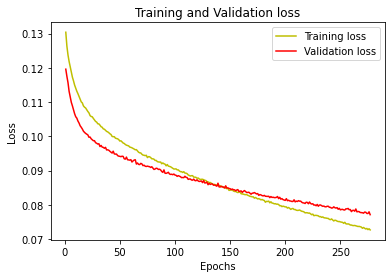

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

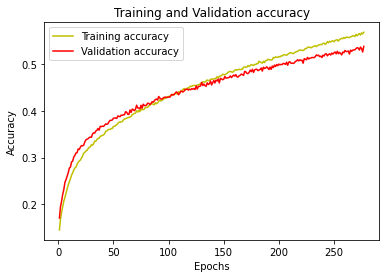

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# test model
dictionary = {0: 'ANGER', 1: 'CONTEMPT', 2: 'DISGUST', 3: 'FEAR', 4: 'HAPPINESS',  5: 'NEUTRAL', 6: 'SADNESS', 7: 'SURPRISE'}
target_name = [dictionary[i] for i in range(len(dictionary))]

value = model.predict(X_test)
y_pred = np.argmax(value, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true,y_pred, target_names=target_name, digits=4))

print(y_test.shape, y_true.shape)

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dictionary)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

              precision    recall  f1-score   support

       ANGER     0.5104    0.5069    0.5086      1016
    CONTEMPT     0.5462    0.5717    0.5587       899
     DISGUST     0.5577    0.5494    0.5535      1003
        FEAR     0.5205    0.4800    0.4995       977
   HAPPINESS     0.6345    0.7088    0.6696       982
     NEUTRAL     0.4781    0.4598    0.4688       996
     SADNESS     0.5164    0.4885    0.5021      1001
    SURPRISE     0.6273    0.6517    0.6393       847

    accuracy                         0.5497      7721
   macro avg     0.5489    0.5521    0.5500      7721
weighted avg     0.5472    0.5497    0.5479      7721

(7721, 8) (7721,)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

ANGER
Epoch 1/210


KeyboardInterrupt: 

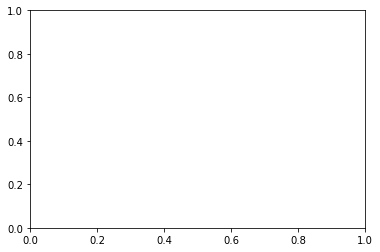

In [13]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for idx in range(len(dictionary)):
    print(dictionary[idx])

    emo_feature = np.copy(X_train)
    emo_target = list(label[idx] for label in y_train)
    emo_target = np.array(emo_target)

    X = emo_feature
    y = emo_target

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train, val) in enumerate(cv.split(X, y)):
        X_train_kf, X_val_kf = X[train], X[val]
        y_train_kf, y_val_kf = y[train], y[val]

        le = preprocessing.LabelEncoder()
        y_train_kf = to_categorical(y_train_kf)
        y_val_kf = to_categorical(y_val_kf)

        model = create_model_best_param(best_params, 2)
        model.fit(X_train_kf,
                    y_train_kf,
                    # validation_data=(X_val_kf, y_val_kf,),
                    batch_size=best_params['batch_size'],
                    epochs=best_params["epochs"],
                    verbose=2)

        # predict
        y_pred = model.predict(X_val_kf).ravel()
        y_val_kf = y_val_kf.ravel()

        print('====================Fold ', i , '====================')

        # plot ROC curve
        viz = RocCurveDisplay.from_predictions(y_val_kf, y_pred, ax=ax, name="ROC fold {}".format(i), alpha=0.3, lw=1,)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(cwd + '/../graph/' + dictionary[idx] + '/ann_relu.jpg')
    plt.show()

In [22]:
from sklearn.metrics import roc_curve, auc

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

model = create_model_best_param(best_params, 8)
model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val,), 
                    batch_size=best_params['batch_size'], 
                    epochs=1, #int(X_train.shape[0]/best_params['batch_size']), 
                    verbose=2)

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)


'''
model = create_model_best_param(best_params, 8)
model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val,), 
                    batch_size=best_params['batch_size'], 
                    epochs=int(X_train.shape[0]/best_params['batch_size']), 
                    verbose=2)
y_score = model.decision_function(X_test)

# ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(dictionary)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curve
plt.figure()
for i in range(len(dictionary)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (area = {1:0.2f})'.format(dictionary[i], roc_auc[i]))

# middle line
plt.plot([0, 1], [0, 1], 'k--')

# mean line
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver operating characteristic (multi-class)")
plt.legend(loc="lower right")
plt.savefig(cwd + '/../graph/ann_relu_allemotion.jpg')
plt.show()
'''

278/278 - 12s - loss: 0.1318 - accuracy: 0.1343 - val_loss: 0.1207 - val_accuracy: 0.1574


ValueError: multilabel-indicator format is not supported

In [ ]:
name = 'model_relu_best'
path = cwd + "/model/" + name
if os.path.exists(path):
    shutil.rmtree(path)
os.makedirs(path)

model.save(path)
# model = keras.models.load_model(path)